# CS345 Final Project

### Project Imports

In [8]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

### Load data

In [9]:
def load_news_dataset(dataset_name: str):
    base_path = os.getcwd() + '/data'
    dataset_path = Path(base_path) / dataset_name
    if not dataset_path.exists():
        raise FileNotFoundError(f"Dataset path not found: {dataset_path}")

    # load corpus.tsv
    corpus_path = dataset_path / "corpus.tsv"
    df = pd.read_csv(corpus_path, sep="\t")
    
    # load splits
    splits_path = dataset_path / "splits.json"
    splits = {}
    if splits_path.exists():
        with open(splits_path, "r") as f:
            splits = json.load(f)

    # load feature JSONs from features directory
    features_dir = dataset_path / "features"
    feature_data = {}
    if features_dir.exists():
        for json_file in features_dir.glob("*.json"):
            feature_name = json_file.stem
            with open(json_file, "r") as f:
                feature_data[feature_name] = json.load(f)
    
    return df, splits, feature_data

### ACL Dataset

In [10]:
acl_df, acl_splits, acl_features = load_news_dataset("acl2020")

acl_split_data = acl_splits.get('0', {})
acl_train_split_size = len(acl_split_data.get('train', []))
acl_test_split_size = len(acl_split_data.get('test', []))
acl_train_urls = acl_split_data.get('train', [])
acl_test_urls = acl_split_data.get('test', [])

print("ACL2020 Dataset:")
print(f"Articles: {len(acl_df)}")
print(f"Columns: {list(acl_df.columns)}")
print(f"Available features: {list(acl_features.keys())}")
print(f"Split sizes: train={acl_train_split_size} test={acl_test_split_size}")
print(acl_df.shape)

ACL2020 Dataset:
Articles: 859
Columns: ['source_url', 'source_url_normalized', 'ref', 'fact', 'bias']
Available features: ['youtube_subs', 'has_twitter', 'has_wikipedia', 'twitter_profile', 'youtube_numerical', 'youtube_fulltext', 'has_youtube', 'twitter_followers', 'has_facebook', 'articles_body_bert', 'youtube_nela', 'youtube_opensmile', 'articles_title_bert', 'wikipedia_content']
Split sizes: train=687 test=172
(859, 5)


### EMNLP Dataset

In [11]:
emnlp_df, emnlp_splits, emnlp_features = load_news_dataset("emnlp18")

emnlp_split_data = emnlp_splits.get('0', {})
emnlp_train_split_size = len(emnlp_split_data.get('train', []))
emnlp_test_split_size = len(emnlp_split_data.get('test', []))

print("EMNLP Dataset:")
print(f"Articles: {len(emnlp_df)}")
print(f"Columns: {list(emnlp_df.columns)}")
print(f"Available features: {list(emnlp_features.keys())}")
print(f"Split sizes: train={emnlp_train_split_size} test={emnlp_test_split_size}")
print(emnlp_df.shape)

EMNLP Dataset:
Articles: 1066
Columns: ['source_url', 'source_url_normalized', 'ref', 'fact', 'bias']
Available features: ['twitter_urlmatch', 'has_twitter', 'wikipedia_toc', 'has_wikipedia', 'twitter_description', 'twitter_created_at', 'twitter_haslocation', 'articles_body_glove', 'twitter_engagement', 'twitter_verified', 'url_structure', 'articles_title_glove', 'alexa', 'wikipedia_categories', 'wikipedia_summary', 'wikipedia_content']
Split sizes: train=851 test=215
(1066, 5)


### Baseline Metrics: ACL Bias Classification

In [12]:
# get BERT embeds
bert_features = acl_features['articles_body_bert']

# split by source_url
train_df = acl_df[acl_df['source_url_normalized'].isin(acl_train_urls)]
test_df = acl_df[acl_df['source_url_normalized'].isin(acl_test_urls)]

# use source_url_normalized as key
X_train = np.array([bert_features[url] for url in train_df['source_url_normalized']])
X_test = np.array([bert_features[url] for url in test_df['source_url_normalized']])
y_train = train_df['bias'].values
y_test = test_df['bias'].values

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (687, 768)
X_test shape: (172, 768)


In [13]:
# train logistic regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Baseline Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Baseline Accuracy: 0.5523

Classification Report:
              precision    recall  f1-score   support

      center       0.47      0.83      0.60        46
        left       0.50      0.02      0.04        55
       right       0.63      0.79      0.70        71

    accuracy                           0.55       172
   macro avg       0.53      0.54      0.44       172
weighted avg       0.55      0.55      0.46       172



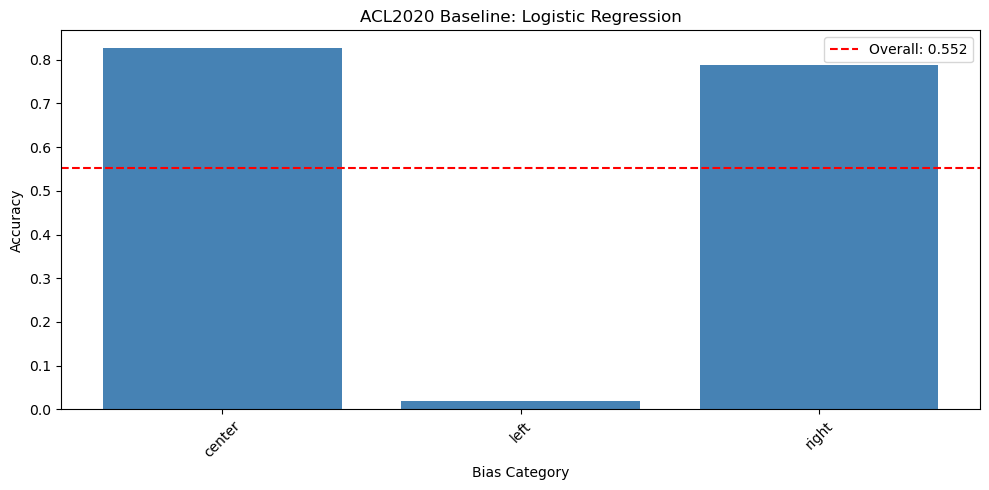

In [14]:
# plot accuracy by class
classes = np.unique(y_test)
class_acc = [accuracy_score(y_test[y_test == c], y_pred[y_test == c]) for c in classes]

plt.figure(figsize=(10, 5))
plt.bar(classes, class_acc, color='steelblue')
plt.axhline(y=accuracy, color='red', linestyle='--', label=f'Overall: {accuracy:.3f}')
plt.xlabel('Bias Category')
plt.ylabel('Accuracy')
plt.title('ACL2020 Baseline: Logistic Regression')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### SVM Model

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Train SVM with class balancing
svm_balanced = SVC(
    kernel='rbf', 
    random_state=42,
    class_weight='balanced',
    C=1.0,
    gamma='scale'
)

print("Training balanced SVM...")
svm_balanced.fit(X_train_scaled, y_train)

y_pred_balanced = svm_balanced.predict(X_test_scaled)
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)

print(f"\nBalanced SVM Accuracy: {accuracy_balanced:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_balanced, zero_division=0))

# Check predictions distribution
print(f"\nBalanced SVM predictions distribution:")
print(pd.Series(y_pred_balanced).value_counts().sort_index())

# Compare all models
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"Logistic Regression:  {accuracy:.4f}")
print(f"SVM (balanced):       {accuracy_balanced:.4f}")
print("="*50)

Training balanced SVM...

Balanced SVM Accuracy: 0.5756

Classification Report:
              precision    recall  f1-score   support

      center       0.71      0.43      0.54        46
        left       0.43      0.53      0.48        55
       right       0.65      0.70      0.68        71

    accuracy                           0.58       172
   macro avg       0.60      0.56      0.56       172
weighted avg       0.60      0.58      0.58       172


Balanced SVM predictions distribution:
center    28
left      67
right     77
Name: count, dtype: int64

MODEL COMPARISON
Logistic Regression:  0.5523
SVM (balanced):       0.5756


### Random Forest Model

Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes for classification. It can capture non-linear relationships and is less prone to overfitting than individual decision trees. We'll compare its performance against Logistic Regression and SVM.

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\nRandom Forest Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# Check predictions distribution
print(f"\nRandom Forest predictions distribution:")
print(pd.Series(y_pred_rf).value_counts().sort_index())

# Compare all models
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"Logistic Regression:  {accuracy:.4f}")
print(f"SVM (balanced):       {accuracy_balanced:.4f}")
print(f"Random Forest:        {accuracy_rf:.4f}")
print("="*50)

Training Random Forest...

Random Forest Accuracy: 0.5756

Classification Report:
              precision    recall  f1-score   support

      center       0.70      0.41      0.52        46
        left       0.42      0.55      0.48        55
       right       0.68      0.70      0.69        71

    accuracy                           0.58       172
   macro avg       0.60      0.55      0.56       172
weighted avg       0.60      0.58      0.58       172


Random Forest predictions distribution:
center    27
left      71
right     74
Name: count, dtype: int64

MODEL COMPARISON
Logistic Regression:  0.5523
SVM (balanced):       0.5756
Random Forest:        0.5756


### Confusion Matrices

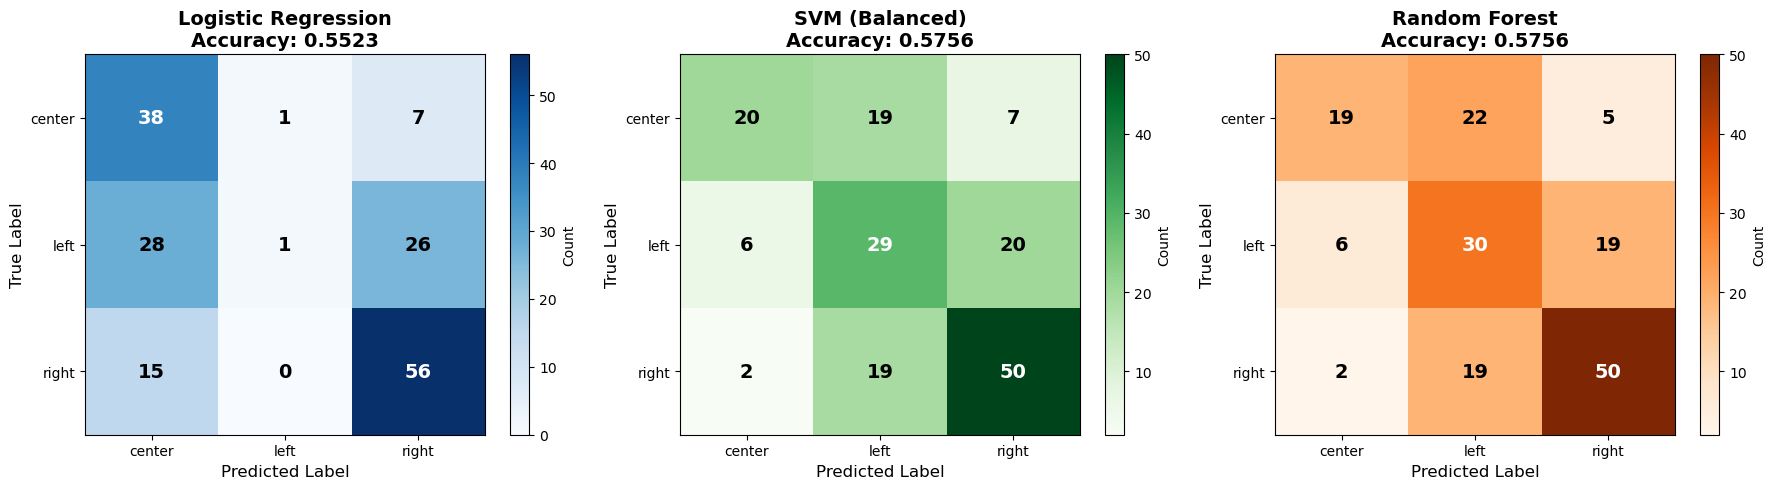

In [18]:
# Create confusion matrices
cm_lr = confusion_matrix(y_test, y_pred)
cm_svm = confusion_matrix(y_test, y_pred_balanced)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

class_labels = ['center', 'left', 'right']

# Logistic Regression
im1 = axes[0].imshow(cm_lr, cmap='Blues', aspect='auto')
axes[0].set_title(f'Logistic Regression\nAccuracy: {accuracy:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_xticks(range(len(class_labels)))
axes[0].set_yticks(range(len(class_labels)))
axes[0].set_xticklabels(class_labels)
axes[0].set_yticklabels(class_labels)

for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text_color = 'white' if cm_lr[i, j] > cm_lr.max()/2 else 'black'
        axes[0].text(j, i, cm_lr[i, j], ha='center', va='center', 
                     color=text_color, fontsize=14, fontweight='bold')

plt.colorbar(im1, ax=axes[0], label='Count')

# SVM Balanced
im2 = axes[1].imshow(cm_svm, cmap='Greens', aspect='auto')
axes[1].set_title(f'SVM (Balanced)\nAccuracy: {accuracy_balanced:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_xticks(range(len(class_labels)))
axes[1].set_yticks(range(len(class_labels)))
axes[1].set_xticklabels(class_labels)
axes[1].set_yticklabels(class_labels)

for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text_color = 'white' if cm_svm[i, j] > cm_svm.max()/2 else 'black'
        axes[1].text(j, i, cm_svm[i, j], ha='center', va='center',
                     color=text_color, fontsize=14, fontweight='bold')

plt.colorbar(im2, ax=axes[1], label='Count')

# Random Forest
im3 = axes[2].imshow(cm_rf, cmap='Oranges', aspect='auto')
axes[2].set_title(f'Random Forest\nAccuracy: {accuracy_rf:.4f}', 
                  fontsize=14, fontweight='bold')
axes[2].set_ylabel('True Label', fontsize=12)
axes[2].set_xlabel('Predicted Label', fontsize=12)
axes[2].set_xticks(range(len(class_labels)))
axes[2].set_yticks(range(len(class_labels)))
axes[2].set_xticklabels(class_labels)
axes[2].set_yticklabels(class_labels)

for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text_color = 'white' if cm_rf[i, j] > cm_rf.max()/2 else 'black'
        axes[2].text(j, i, cm_rf[i, j], ha='center', va='center',
                     color=text_color, fontsize=14, fontweight='bold')

plt.colorbar(im3, ax=axes[2], label='Count')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

### Asymmetric Bias Analysis

This analysis examines whether our models exhibit asymmetric prediction errors between political categories. Specifically, we compare:
- **Left → Right errors**: How often articles that are truly "left" are misclassified as "right"
- **Right → Left errors**: How often articles that are truly "right" are misclassified as "left"

An asymmetry in these error rates could indicate that the model has learned a directional bias, potentially favoring one political orientation over another. This is important for understanding model fairness in political bias detection.

In [19]:
def asymmetric_bias_analysis(y_true, y_pred, model_name):
    """
    Analyze asymmetric prediction errors between left and right categories.
    Returns counts and rates of left→right and right→left misclassifications.
    """
    # Convert to numpy arrays for easier indexing
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Count left articles predicted as right
    left_as_right = np.sum((y_true == 'left') & (y_pred == 'right'))
    total_left = np.sum(y_true == 'left')
    left_to_right_rate = left_as_right / total_left if total_left > 0 else 0
    
    # Count right articles predicted as left
    right_as_left = np.sum((y_true == 'right') & (y_pred == 'left'))
    total_right = np.sum(y_true == 'right')
    right_to_left_rate = right_as_left / total_right if total_right > 0 else 0
    
    # Calculate asymmetry (positive = more left→right errors, negative = more right→left errors)
    asymmetry = left_to_right_rate - right_to_left_rate
    
    return {
        'Model': model_name,
        'Left→Right (count)': left_as_right,
        'Left→Right (rate)': left_to_right_rate,
        'Right→Left (count)': right_as_left,
        'Right→Left (rate)': right_to_left_rate,
        'Asymmetry': asymmetry,
        'Total Left': total_left,
        'Total Right': total_right
    }

# Analyze all models
asym_lr = asymmetric_bias_analysis(y_test, y_pred, 'Logistic Regression')
asym_svm = asymmetric_bias_analysis(y_test, y_pred_balanced, 'SVM (Balanced)')
asym_rf = asymmetric_bias_analysis(y_test, y_pred_rf, 'Random Forest')

asym_df = pd.DataFrame([asym_lr, asym_svm, asym_rf])

print("ASYMMETRIC BIAS ANALYSIS")
print("="*80)
print("\nThis analysis compares how often each model confuses left for right vs right for left.")
print("A positive asymmetry means the model more often predicts left articles as right.")
print("A negative asymmetry means the model more often predicts right articles as left.\n")
print(asym_df.to_string(index=False))
print("\n" + "="*80)

ASYMMETRIC BIAS ANALYSIS

This analysis compares how often each model confuses left for right vs right for left.
A positive asymmetry means the model more often predicts left articles as right.
A negative asymmetry means the model more often predicts right articles as left.

              Model  Left→Right (count)  Left→Right (rate)  Right→Left (count)  Right→Left (rate)  Asymmetry  Total Left  Total Right
Logistic Regression                  26           0.472727                   0           0.000000   0.472727          55           71
     SVM (Balanced)                  20           0.363636                  19           0.267606   0.096031          55           71
      Random Forest                  19           0.345455                  19           0.267606   0.077849          55           71



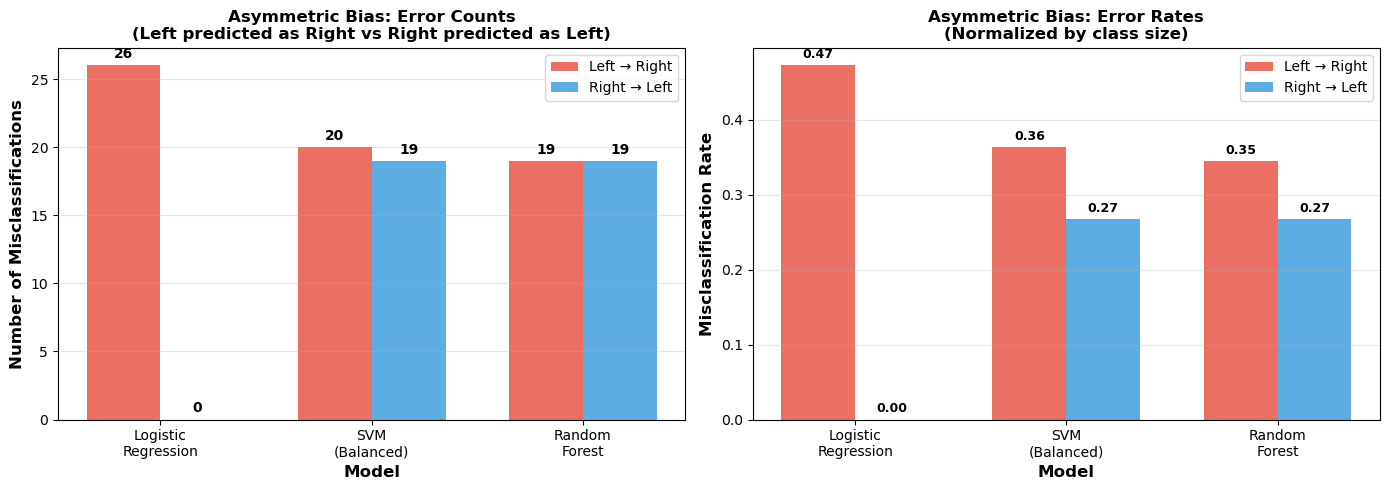

In [20]:
# Visualize asymmetric bias
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ['Logistic\nRegression', 'SVM\n(Balanced)', 'Random\nForest']
x = np.arange(len(models))
width = 0.35

# Left panel: Error counts
left_to_right_counts = [asym_lr['Left→Right (count)'], asym_svm['Left→Right (count)'], asym_rf['Left→Right (count)']]
right_to_left_counts = [asym_lr['Right→Left (count)'], asym_svm['Right→Left (count)'], asym_rf['Right→Left (count)']]

bars1 = axes[0].bar(x - width/2, left_to_right_counts, width, label='Left → Right', color='#e74c3c', alpha=0.8)
bars2 = axes[0].bar(x + width/2, right_to_left_counts, width, label='Right → Left', color='#3498db', alpha=0.8)

axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Misclassifications', fontsize=12, fontweight='bold')
axes[0].set_title('Asymmetric Bias: Error Counts\n(Left predicted as Right vs Right predicted as Left)', 
                  fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    axes[0].annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontweight='bold')

# Right panel: Error rates
left_to_right_rates = [asym_lr['Left→Right (rate)'], asym_svm['Left→Right (rate)'], asym_rf['Left→Right (rate)']]
right_to_left_rates = [asym_lr['Right→Left (rate)'], asym_svm['Right→Left (rate)'], asym_rf['Right→Left (rate)']]

bars3 = axes[1].bar(x - width/2, left_to_right_rates, width, label='Left → Right', color='#e74c3c', alpha=0.8)
bars4 = axes[1].bar(x + width/2, right_to_left_rates, width, label='Right → Left', color='#3498db', alpha=0.8)

axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Misclassification Rate', fontsize=12, fontweight='bold')
axes[1].set_title('Asymmetric Bias: Error Rates\n(Normalized by class size)', 
                  fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend(fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    axes[1].annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontweight='bold', fontsize=9)
for bar in bars4:
    height = bar.get_height()
    axes[1].annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('asymmetric_bias_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

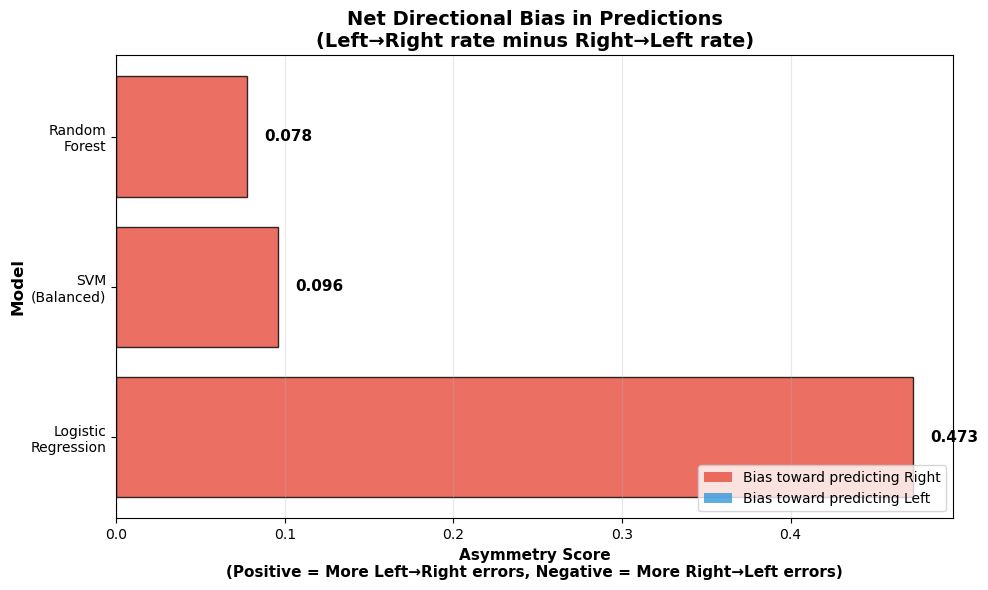


Interpretation:
------------------------------------------------------------
Logistic Regression: Shows bias toward predicting 'right' (asymmetry: 0.473)
SVM (Balanced): Shows bias toward predicting 'right' (asymmetry: 0.096)
Random Forest: Shows bias toward predicting 'right' (asymmetry: 0.078)


In [21]:
# Asymmetry visualization - net directional bias
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Logistic\nRegression', 'SVM\n(Balanced)', 'Random\nForest']
asymmetries = [asym_lr['Asymmetry'], asym_svm['Asymmetry'], asym_rf['Asymmetry']]
colors = ['#e74c3c' if a > 0 else '#3498db' for a in asymmetries]

bars = ax.barh(models, asymmetries, color=colors, alpha=0.8, edgecolor='black')

ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
ax.set_xlabel('Asymmetry Score\n(Positive = More Left→Right errors, Negative = More Right→Left errors)', 
              fontsize=11, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Net Directional Bias in Predictions\n(Left→Right rate minus Right→Left rate)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for bar, val in zip(bars, asymmetries):
    x_pos = val + 0.01 if val >= 0 else val - 0.01
    ha = 'left' if val >= 0 else 'right'
    ax.annotate(f'{val:.3f}',
                xy=(x_pos, bar.get_y() + bar.get_height()/2),
                va='center', ha=ha, fontweight='bold', fontsize=11)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', alpha=0.8, label='Bias toward predicting Right'),
                   Patch(facecolor='#3498db', alpha=0.8, label='Bias toward predicting Left')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('asymmetry_score.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("-" * 60)
for model, asym in zip(['Logistic Regression', 'SVM (Balanced)', 'Random Forest'], asymmetries):
    if asym > 0.05:
        print(f"{model}: Shows bias toward predicting 'right' (asymmetry: {asym:.3f})")
    elif asym < -0.05:
        print(f"{model}: Shows bias toward predicting 'left' (asymmetry: {asym:.3f})")
    else:
        print(f"{model}: Relatively balanced between left/right errors (asymmetry: {asym:.3f})")

### Demographic Equality

DEMOGRAPHIC EQUALITY ANALYSIS
              Model  Class  Actual Distribution  Predicted Distribution  Difference
Logistic Regression center             0.267442                0.470930    0.203488
Logistic Regression   left             0.319767                0.011628   -0.308140
Logistic Regression  right             0.412791                0.517442    0.104651
     SVM (Balanced) center             0.267442                0.162791   -0.104651
     SVM (Balanced)   left             0.319767                0.389535    0.069767
     SVM (Balanced)  right             0.412791                0.447674    0.034884
      Random Forest center             0.267442                0.156977   -0.110465
      Random Forest   left             0.319767                0.412791    0.093023
      Random Forest  right             0.412791                0.430233    0.017442



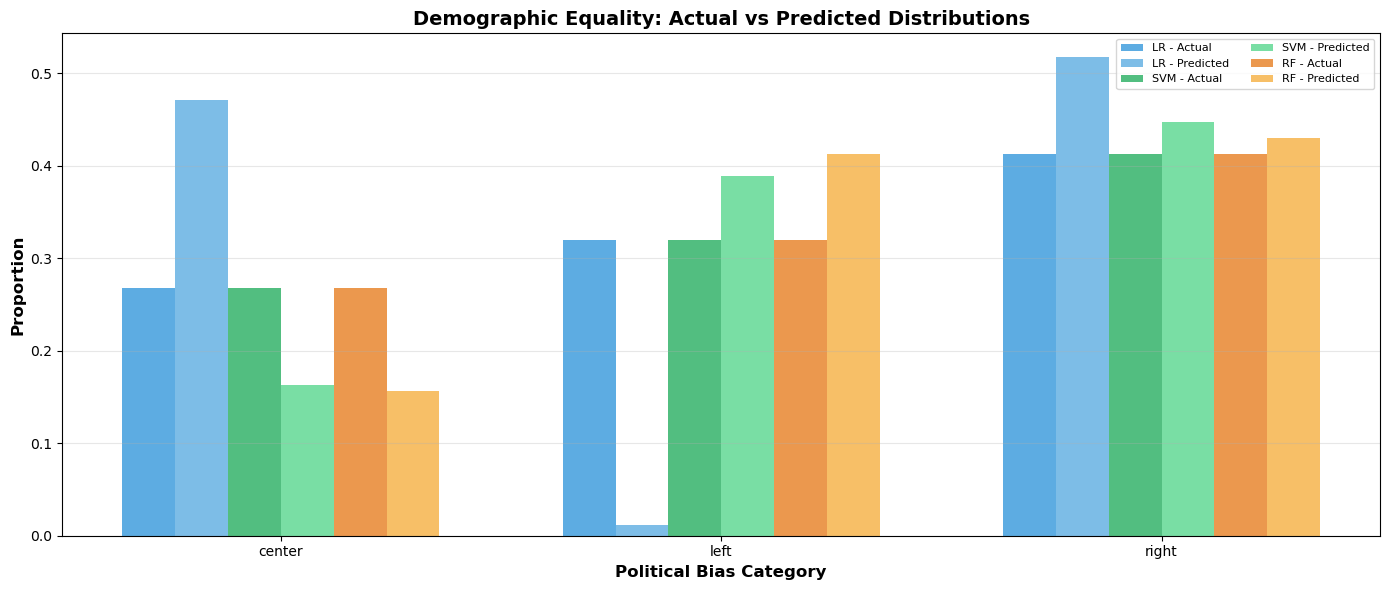

In [22]:
# Calculate prediction rates by class
def demographic_parity(y_true, y_pred, model_name):
    """Check if prediction rates are equal across groups"""
    total = len(y_pred)
    
    results = []
    for label in ['center', 'left', 'right']:
        pred_rate = (y_pred == label).sum() / total
        true_rate = (y_true == label).sum() / total
        
        results.append({
            'Model': model_name,
            'Class': label,
            'Actual Distribution': true_rate,
            'Predicted Distribution': pred_rate,
            'Difference': pred_rate - true_rate
        })
    
    return pd.DataFrame(results)

# Analyze all models
demo_lr = demographic_parity(y_test, y_pred, 'Logistic Regression')
demo_svm = demographic_parity(y_test, y_pred_balanced, 'SVM (Balanced)')
demo_rf = demographic_parity(y_test, y_pred_rf, 'Random Forest')
demo_combined = pd.concat([demo_lr, demo_svm, demo_rf])

print("DEMOGRAPHIC EQUALITY ANALYSIS")
print("="*70)
print(demo_combined.to_string(index=False))
print("\n" + "="*70)

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))

classes = ['center', 'left', 'right']
x = np.arange(len(classes))
width = 0.12

colors_lr = ['#3498db', '#5dade2']  # Blues for LR
colors_svm = ['#27ae60', '#58d68d']  # Greens for SVM
colors_rf = ['#e67e22', '#f5b041']  # Oranges for RF

# Logistic Regression
lr_actual = demo_lr['Actual Distribution'].values
lr_pred = demo_lr['Predicted Distribution'].values

# SVM
svm_actual = demo_svm['Actual Distribution'].values
svm_pred = demo_svm['Predicted Distribution'].values

# Random Forest
rf_actual = demo_rf['Actual Distribution'].values
rf_pred = demo_rf['Predicted Distribution'].values

bars1 = ax.bar(x - 2.5*width, lr_actual, width, label='LR - Actual', 
               color=colors_lr[0], alpha=0.8)
bars2 = ax.bar(x - 1.5*width, lr_pred, width, label='LR - Predicted', 
               color=colors_lr[1], alpha=0.8)
bars3 = ax.bar(x - 0.5*width, svm_actual, width, label='SVM - Actual', 
               color=colors_svm[0], alpha=0.8)
bars4 = ax.bar(x + 0.5*width, svm_pred, width, label='SVM - Predicted', 
               color=colors_svm[1], alpha=0.8)
bars5 = ax.bar(x + 1.5*width, rf_actual, width, label='RF - Actual', 
               color=colors_rf[0], alpha=0.8)
bars6 = ax.bar(x + 2.5*width, rf_pred, width, label='RF - Predicted', 
               color=colors_rf[1], alpha=0.8)

ax.set_xlabel('Political Bias Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Proportion', fontsize=12, fontweight='bold')
ax.set_title('Demographic Equality: Actual vs Predicted Distributions', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend(fontsize=8, loc='upper right', ncol=2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('demographic_equality.png', dpi=300, bbox_inches='tight')
plt.show()

## Model Improvements

The baseline models achieve ~55-58% accuracy on this 3-class classification problem. We'll explore several techniques to improve performance:

1. **Hyperparameter Tuning**: GridSearchCV for SVM and Random Forest
2. **PCA Dimensionality Reduction**: Reduce 768 features to capture main variance
3. **Gradient Boosting**: XGBoost-style ensemble method
4. **Combined Features**: Use both body and title BERT embeddings
5. **Neural Network (MLP)**: Multi-layer perceptron with regularization

In [ ]:
# Store baseline results for comparison
baseline_results = {
    'Logistic Regression (Baseline)': accuracy,
    'SVM RBF (Baseline)': accuracy_balanced,
    'Random Forest (Baseline)': accuracy_rf
}

print("BASELINE RESULTS")
print("="*50)
for model, acc in baseline_results.items():
    print(f"{model}: {acc:.4f}")
print("="*50)

### 1. Hyperparameter Tuning with GridSearchCV

We'll use cross-validation to find optimal hyperparameters for SVM and Random Forest.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# SVM Hyperparameter Tuning
print("="*60)
print("SVM HYPERPARAMETER TUNING")
print("="*60)

svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(
    SVC(class_weight='balanced', random_state=42),
    svm_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Training SVM with GridSearchCV...")
svm_grid.fit(X_train_scaled, y_train)

print(f"\nBest SVM Parameters: {svm_grid.best_params_}")
print(f"Best CV Score: {svm_grid.best_score_:.4f}")

y_pred_svm_tuned = svm_grid.predict(X_test_scaled)
accuracy_svm_tuned = accuracy_score(y_test, y_pred_svm_tuned)
print(f"Test Accuracy: {accuracy_svm_tuned:.4f}")

In [ ]:
# Random Forest Hyperparameter Tuning
print("\n" + "="*60)
print("RANDOM FOREST HYPERPARAMETER TUNING")
print("="*60)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Training Random Forest with GridSearchCV...")
rf_grid.fit(X_train_scaled, y_train)

print(f"\nBest RF Parameters: {rf_grid.best_params_}")
print(f"Best CV Score: {rf_grid.best_score_:.4f}")

y_pred_rf_tuned = rf_grid.predict(X_test_scaled)
accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
print(f"Test Accuracy: {accuracy_rf_tuned:.4f}")

### 2. PCA Dimensionality Reduction

Reducing the 768-dimensional BERT embeddings to capture the main variance may help reduce overfitting.